# SRC scaling factors $a_2$

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ July 24, 2023

We calculate the SRC scaling factor $a_2$ using the ratio of single-nucleon momentum distributions at high momentum.

_Last update:_ July 28, 2023

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline

In [2]:
# Imports from scripts
from scripts.figures import set_rc_parameters, label_lambda, label_nucleus
from scripts.integration import (
    gaussian_quadrature_mesh, unattach_weights_from_vector
)
from scripts.momentum_distributions import MomentumDistribution
from scripts.potentials import Potential
from scripts.src_scaling_factor import compute_a2
from scripts.wave_function import wave_function

from test_momentum_distribution_script import load_momentum_distribution

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

## Extraction procedure

$a_2$ is extracted from integrating single-nucleon probability distributions over a high momentum range

$$
a_2(A) = \lim_{q\to\infty} \frac{P^A(q)}{P^d(q)} \approx \frac{2}{A}
    \frac{\int_{\Delta q^{\rm{high}}} dq \, q^2 n^A(q)}{\int_{\Delta q^{\rm{high}}} dq \, q^2 n^d(q)}
$$

where

$$
n^A(q) = \frac{1}{A} \bigl( n^A_p(q) + n^A_n(q) \bigr).
$$

We vary $\Delta q^{\rm{high}}$ from $[2,\infty)$ fm$^{-1}$ to $[3.8,4.5]$ fm$^{-1}$ to establish error bars.

See the following references for details.

_A. J. Tropiano, S. K. Bogner, and R. J. Furnstahl, [Phys. Rev. C __104__, 034311 (2021)](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.104.034311)_

_J. Ryckebusch, W. Cosyn, T. Vieijra, and C. Casert, [Phys. Rev. C __100__, 054620 (2019)](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.100.054620)_

In [4]:
def get_deuteron_func(kvnn, kmax, kmid, ntot):
    """Get deuteron momentum distribution from Hamiltonian."""
    
    potential = Potential(kvnn, '3S1', kmax, kmid, ntot)
    
    # Momentum array and weights in fm^-1
    q_array, q_weights = potential.load_mesh()
    
    # Hamiltonian with integration weights [MeV]
    H_matrix = potential.load_hamiltonian()
    
    # Deuteron wave function with integration weights [unitless]
    psi_d_unitless = wave_function(H_matrix, eps=-2.22)
    
    # Deuteron wave function without integration weights [fm^3/2]
    psi_d = unattach_weights_from_vector(q_array, q_weights, psi_d_unitless,
                                         coupled_channel=True)
    
    # Deuteron momentum distribution normalized as \int dq q^2 n(q) = 1
    n_d_array = 2/np.pi * (psi_d[:ntot] ** 2 + psi_d[ntot:] ** 2)  # fm^3

    # Interpolate momentum distribution
    n_d_func = InterpolatedUnivariateSpline(q_array, n_d_array)
    
    return n_d_func

In [5]:
def a2_with_errorbar(A, n_p_func, n_n_func, n_d_func, kmax):
    """Get average a_2 using two different high momentum intervals."""
    
    a2_array = np.zeros(2)
    i = 0
    for q_min, q_max, ntot_q in [(2.0, 5.0, 100), (3.8, 4.5, 80)]:
        
        # Create momentum mesh for integration
        q_array, q_weights = gaussian_quadrature_mesh(q_max, ntot_q, xmin=q_min)
                
        # Get arrays of the momentum distributions on the momentum mesh
        n_p_array = n_p_func(q_array)
        n_n_array = n_n_func(q_array)
        n_d_array = n_d_func(q_array)
    
        a2_array[i] = compute_a2(A, n_p_array, n_n_array, n_d_array, q_array,
                                 q_weights)
        
        if a2_array[i] < 0:
            print(A, q_min, q_max)
        
        i += 1

    # Central value
    a2_average = np.average(a2_array)
    a2_error = np.abs(a2_array[0] - a2_array[1]) / 2
    
    return a2_average, a2_error

## Comparison of LDA to Woods-Saxon s.p. states

In [6]:
def compare_to_lda(
        nuclei, kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120, density='Gogny',
        x_limits=(3e0,3e2), y_limits=(0.0, 6.5), xlabel_size=16, ylabel_size=16,
        lambda_label=True
):
    """Plot a_2 for various nuclei comparing LDA to new s.p. state approach."""
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set log-scale on x-axis
    ax.set_xscale('log')
    
    # --- Get data --- #
    # Initialize momentum distribution object and get deuteron distribution
    md = MomentumDistribution(kvnn, kmax, kmid, ntot)
    n_d_lda_func = md.get_deuteron_momentum_distribution('Wegner', lamb,
                                                         interpolate=True)
    n_d_psi_func = get_deuteron_func(kvnn, kmax, kmid, ntot)

    # Initialize array for A and a2
    N = len(nuclei)
    A_array = np.zeros(N)
    a2_lda_array = np.zeros(N)
    a2_lda_errors = np.zeros(N)
    a2_ws_array = np.zeros(N)
    a2_ws_errors = np.zeros(N)
        
    # Loop over nuclei and add each value of a_2 to array
    for i, nucleus in enumerate(nuclei):
            
        # Unpack nucleus information
        nucleus_name, Z, N = nucleus
        A = Z + N
        A_array[i] = A
        
        # -- LDA -- #

        # Get interpolated functions of the momentum distributions
        n_p_lda_func = md.get_single_nucleon_momentum_distribution(
            'proton', nucleus_name, density, ('1S0', '3S1'), 'Wegner', lamb,
            interpolate=True
        )
        n_n_lda_func = md.get_single_nucleon_momentum_distribution(
            'neutron', nucleus_name, density, ('1S0', '3S1'), 'Wegner', lamb,
            interpolate=True
        )

        a2_avg, a2_error = a2_with_errorbar(A, n_p_lda_func, n_n_lda_func,
                                            n_d_lda_func, 10.0)
        a2_lda_array[i] = a2_avg
        a2_lda_errors[i] = a2_error
        
        # -- Woods-Saxon s.p. states -- #

        # Get interpolated functions of the momentum distributions
        k_array, k_weights, n_p_array, _, _, _, _, _, _ = (
            load_momentum_distribution(nucleus_name, 'proton', kvnn, lamb)
        )
        n_p_array *= 4*np.pi  # Normalization factor
        n_p_ws_func = InterpolatedUnivariateSpline(k_array, n_p_array)
        k_array, _, n_n_array, _, _, _, _, _, _ = (
            load_momentum_distribution(nucleus_name, 'neutron', kvnn, lamb)
        )
        n_n_array *= 4*np.pi  # Normalization factor
        n_n_ws_func = InterpolatedUnivariateSpline(k_array, n_n_array)
        
        a2_avg, a2_error = a2_with_errorbar(A, n_p_ws_func, n_n_ws_func,
                                            n_d_psi_func, 10.0)
        a2_ws_array[i] = a2_avg
        a2_ws_errors[i] = a2_error
        

    # Off-set x-axis locations slightly so the points are more visible
    ax.errorbar(
        1.02*A_array, a2_lda_array, yerr=a2_lda_errors, color='red',
        label=f"LDA ({density})", linestyle='', marker='o', markersize=6
    )
    ax.errorbar(
        0.98*A_array, a2_ws_array, yerr=a2_ws_errors, color='blue',
        label=f"Woods-Saxon", linestyle='', marker='o', markersize=6
    )

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("Mass number A", fontsize=xlabel_size)
    ax.set_ylabel(r"$a_2$", fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='lower right', fontsize=16, frameon=False)
    
    # --- Additional labels --- #
    if lambda_label:  # Label \lambda
        ax.add_artist(
            AnchoredText(label_lambda(lamb), loc='upper left',
                         prop=dict(size=18), frameon=False)
        )
        
    plt.show()
    
    return A_array, a2_lda_array, a2_ws_array

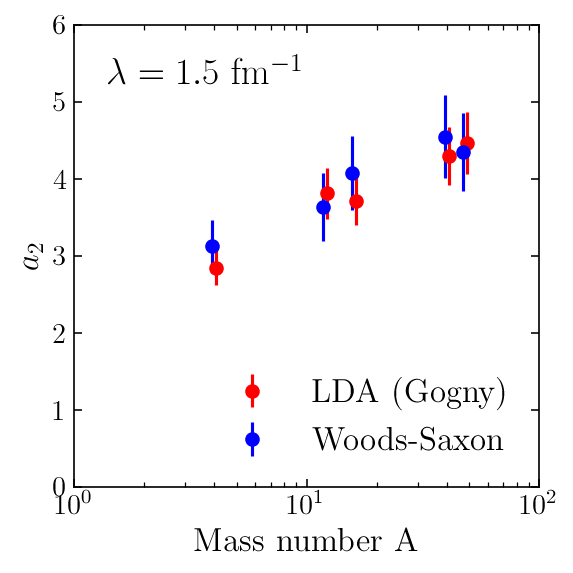

In [7]:
# Compare a2 for He4, C12, O16, Ca40, Ca48, and Pb208 using AV18,
# \lambda = 1.35 (or 1.5?), SLy4

nuclei = (('He4', 2, 2), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20),
          ('Ca48', 20, 28))
kvnn = 6
lamb = 1.5

A_array, a2_lda_array, a2_ws_array = compare_to_lda(
    nuclei, kvnn, lamb, x_limits=(1e0,1e2), y_limits=(0,6))

In [8]:
print(f"{'A':^8s}{'LDA':^10s}{'Woods-Saxon':^10s}")
print('-'*29)
for A, a2_lda, a2_ws in zip(A_array, a2_lda_array, a2_ws_array):
    line = f"{int(A):^8d}{a2_lda:^10.5f}{a2_ws:^10.5f}"
    print(line)

   A       LDA    Woods-Saxon
-----------------------------
   4     2.84616   3.12635  
   12    3.81456   3.63723  
   16    3.72009   4.08172  
   40    4.29724   4.55190  
   48    4.46842   4.35318  


In [9]:
print(f"LDA Ca48/Ca40: {a2_lda_array[-1]/a2_lda_array[-2]}")
print(f"WS Ca48/Ca40: {a2_ws_array[-1]/a2_ws_array[-2]}")

LDA Ca48/Ca40: 1.0398343852658138
WS Ca48/Ca40: 0.9563436372925126


### Plot $\frac{2}{A} \frac{n^A(q)}{n^d(q)}$

In [10]:
def momentum_distribution_ratio(
        nuclei, kvnn, lamb, channels=('1S0','3S1'), kmax=15.0, kmid=3.0,
        ntot=120, density='Gogny', deuteron_wf=False, x_limits=(0,10),
        y_limits=(0.0,10.0), xlabel_size=16, ylabel_size=16, lambda_label=True
):
    """Plot the ratio of 2/A n^A(q)/n^d(q) using LDA momentum distributions."""
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # --- Get data --- #
    # Initialize momentum distribution object and get deuteron distribution
    md = MomentumDistribution(kvnn, kmax, kmid, ntot)
    
    # Use deuteron wavefunction from Hamiltonian?
    if deuteron_wf:
        
        potential = Potential(kvnn, '3S1', kmax, kmid, ntot)
    
        # Momentum array and weights in fm^-1
        q_array, q_weights = potential.load_mesh()
    
        # Hamiltonian with integration weights [MeV]
        H_matrix = potential.load_hamiltonian()
    
        # Deuteron wave function with integration weights [unitless]
        psi_d_unitless = wave_function(H_matrix, eps=-2.22)
    
        # Deuteron wave function without integration weights [fm^3/2]
        psi_d = unattach_weights_from_vector(q_array, q_weights, psi_d_unitless,
                                             coupled_channel=True)
    
        # Deuteron momentum distribution normalized as \int dq q^2 n(q) = 1
        n_d_array = 2/np.pi * (psi_d[:ntot] ** 2 + psi_d[ntot:] ** 2)  # fm^3
        n_d_array /= 4*np.pi/(2*np.pi)**3
    
    # Use LDA to calculate deuteron momentum distribution
    else:
        
        q_array, n_d_array = md.get_deuteron_momentum_distribution('Wegner',
                                                                   lamb)

    # Loop over nuclei and add each value of a_2 to array
    for i, nucleus in enumerate(nuclei):
            
        # Unpack nucleus information
        nucleus_name, Z, N = nucleus
        A = Z + N
        
        # -- LDA -- #

        # Get interpolated functions of the momentum distributions
        q_array, n_p_array = md.get_single_nucleon_momentum_distribution(
            'proton', nucleus_name, density, channels, 'Wegner', lamb)
        q_array, n_n_array = md.get_single_nucleon_momentum_distribution(
            'neutron', nucleus_name, density, channels, 'Wegner', lamb)
        
        # Combine proton plus neutron
        n_A_array = (n_p_array + n_n_array) / A

        # Plot the ratio of A/d
        ratio_array = 2/A * n_A_array / n_d_array
        ax.plot(
            q_array, ratio_array, label=label_nucleus(nucleus_name),
            linewidth=2.0
        )

    # --- Axes limits --- #
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # --- Axes labels --- #
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=xlabel_size)
    ax.set_ylabel(r"$\frac{2}{A} \frac{n^A(q)}{n^d(q)}$", fontsize=ylabel_size)
    
    # --- Legend --- #
    ax.legend(loc='upper left', fontsize=14, frameon=False)
    
    # --- Additional labels --- #
    if lambda_label:  # Label \lambda
        ax.set_title(label_lambda(lamb), fontsize=16)
        
    plt.show()
    
    return q_array, n_d_array, n_A_array

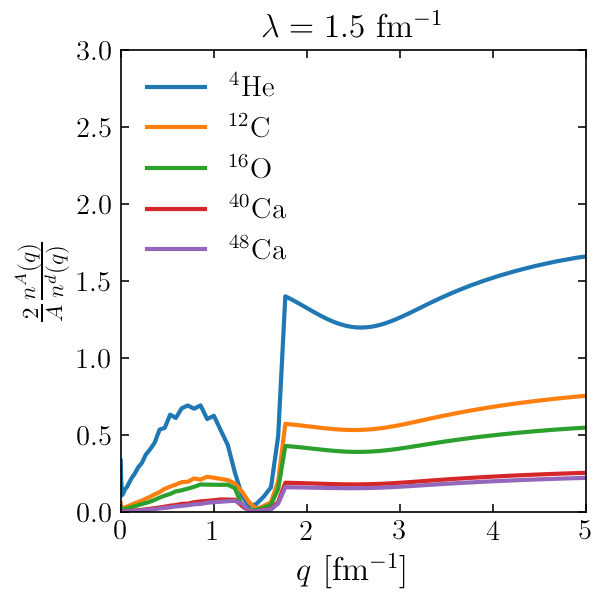

In [11]:
nuclei = (('He4', 2, 2), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20),
          ('Ca48', 20, 28))
kvnn = 6
lamb = 1.5

q_array, n_d_array, n_A_array = momentum_distribution_ratio(
    nuclei, kvnn, lamb, x_limits=(0,5), y_limits=(0.0,3.0)
)

## Test $\lambda$ dependence of $a_2$

In [ ]:
# Do LDA for lambda_array similar to O16 \lambda dependence plot

## Compute $\frac{^{48}\rm{Ca}}{^{40}\rm{Ca}}$

In [ ]:
# Ca48 / Ca40 ratio

density = 'SLy4'
# density = 'Gogny'
channels = ('1S0', '3S1')
kvnn = 6
kmax, kmid, ntot = 15.0, 3.0, 120
generator = 'Wegner'
# lamb = 1.35
lamb = 1.5

md = MomentumDistribution(kvnn, kmax, kmid, ntot)
n_d_func = md.get_deuteron_momentum_distribution(generator, lamb,
                                                 interpolate=True)

In [ ]:
# Ca48

nucleus_name, A = 'Ca48', 48

# Get interpolated functions of the momentum distributions
n_p_func = md.get_single_nucleon_momentum_distribution(
    'proton', nucleus_name, density, channels, generator, lamb,
    interpolate=True
)
n_n_func = md.get_single_nucleon_momentum_distribution(
    'neutron', nucleus_name, density, channels, generator, lamb,
    interpolate=True
)

a2_ca48_average = 0
for q_min, q_max, ntot_q in ((2.0, kmax, 40), (3.8, 4.5, 80)):
            
    # Create momentum mesh for integration
    q_array, q_weights = gaussian_quadrature_mesh(q_max, ntot_q, xmin=q_min)
                
    # Get arrays of the momentum distributions on the momentum mesh
    n_p_array = n_p_func(q_array)
    n_n_array = n_n_func(q_array)
    n_d_array = n_d_func(q_array)
    
    a2 = compute_a2(A, n_p_array, n_n_array, n_d_array, q_array, q_weights)
    a2_ca48_average += 1/2 * a2

In [ ]:
# Ca40

nucleus_name, A = 'Ca40', 40

# Get interpolated functions of the momentum distributions
n_p_func = md.get_single_nucleon_momentum_distribution(
    'proton', nucleus_name, density, channels, generator, lamb,
    interpolate=True
)
n_n_func = md.get_single_nucleon_momentum_distribution(
    'neutron', nucleus_name, density, channels, generator, lamb,
    interpolate=True
)

a2_ca40_average = 0
for q_min, q_max, ntot_q in ((2.0, kmax, 40), (3.8, 4.5, 80)):
            
    # Create momentum mesh for integration
    q_array, q_weights = gaussian_quadrature_mesh(q_max, ntot_q, xmin=q_min)
                
    # Get arrays of the momentum distributions on the momentum mesh
    n_p_array = n_p_func(q_array)
    n_n_array = n_n_func(q_array)
    n_d_array = n_d_func(q_array)
    
    a2 = compute_a2(A, n_p_array, n_n_array, n_d_array, q_array, q_weights)
    a2_ca40_average += 1/2 * a2

In [ ]:
# Ratio of Ca48 a2 over Ca40 a2
# Insensitive to \lambda = 1.35 vs 1.5 fm^-1

ratio = a2_ca48_average / a2_ca40_average
print(f"Ca48 / Ca40 = {ratio:.5f}.")

In [ ]:
# Show ratios of Ca48/Ca40

q_array, n_ca48_p_array = md.get_single_nucleon_momentum_distribution(
    'proton', 'Ca48', density, channels, generator, lamb
)
q_array, n_ca48_n_array = md.get_single_nucleon_momentum_distribution(
    'neutron', 'Ca48', density, channels, generator, lamb
)

q_array, n_ca40_p_array = md.get_single_nucleon_momentum_distribution(
    'proton', 'Ca40', density, channels, generator, lamb
)
q_array, n_ca40_n_array = md.get_single_nucleon_momentum_distribution(
    'neutron', 'Ca40', density, channels, generator, lamb
)

ratio_array = 40/48 * (n_ca48_p_array + n_ca48_n_array) / (
    n_ca40_p_array + n_ca40_n_array)

# y_limits = (0, 2)
y_limits = (0.5, 1.5)

plt.close('all')
f, ax = plt.subplots(figsize=(4,4))
ax.plot(q_array, ratio_array, linewidth=2.0)
ax.set_xlim((0,15))
ax.set_ylim(y_limits)
ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=16)
ax.set_ylabel(r"$^{48}$Ca/$^{40}$Ca", fontsize=16)
plt.show()

## Compare using LDA for deuteron to $\psi_d$

In [ ]:
# First compare a_2 for several nuclei.

In [ ]:
# If necessary, plot the ratio of momentum distributions.

## Other nuclei?

In [ ]:
# List of nuclei will still need (from Fomin's plot):
# 3He, 6Li, 10B, 11B, 54Fe, 58Ni, 64Ni, 232Th

# You have 4He, 7Li, 9Be, 12C, 27Al, 40Ca, 48Ca, 48Ti, 63Cu,
# 107Ag, 118Sn, 197Au